# Project Title

FIFA World Cup 2026: Predicting Success and Uncovering Trends

# Problem Statement

Develop a data-driven approach to -  
1. Predict the top 4 teams in the 2026 FIFA World Cup and
2. Analyze historical trends in team performance metrics to inform success and identify key factors that contribute to a team's chances of advancing to the final stages of the tournament.

# Project Steps

The project will broadly consist of the below steps -  

1. Data Collection and Storage with SQL
2. Data Preprocessing
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Time Series Analysis of Team Performance Metrics
6. Predicting Top 4 Teams for 2026
7. Use the Existing Data for Prediction

# 1. Data Collection and Storage with SQL

Data sourced from Kaggle - Football - FIFA World Cup, 1930 - 2022  

Source link - https://www.kaggle.com/datasets/piterfm/fifa-football-world-cup

Storage with SQL - Using PostgreSQL for our project  
Database Name - FIFA

1. Create Table for wc_all_matches:
   
CREATE TABLE wc_all_matches (
    date DATE,  
    year INT,  
    host_country VARCHAR(100),  
    stage VARCHAR(100),  
    home_team VARCHAR(100),  
    away_team VARCHAR(100),  
    home_score INT,  
    away_score INT,  
    winning_team VARCHAR(100),
    losing_team VARCHAR(100)  
);

2. Create Table for wc_results

CREATE TABLE wc_results (  
    year INT,  
    host VARCHAR(100),  
    winner VARCHAR(100),  
    second VARCHAR(100),  
    third VARCHAR(100),  
    fourth VARCHAR(100),  
    goals_scored INT,  
    avg_goals_per_game FLOAT,  
    teams INT,  
    games INT,  
    attendance INT  
);

# Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import sqlalchemy as db
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2. Data Preprocessing

In [3]:
# Loading Data from SQL

# Define database connection parameters
username = 'postgres'
password = '*******'
host = 'localhost'
database = 'FIFA'

# Create a database connection string
connection_string = f"postgresql://{username}:{password}@{host}/{database}"

# Create a SQLAlchemy engine
engine = db.create_engine(connection_string)

In [4]:
# Load the data from the database into pandas dataframes

wc_all_matches = pd.read_sql_table('wc_all_matches', engine)
wc_results = pd.read_sql_table('wc_results', engine)

In [5]:
wc_all_matches.head(3)

,date,year,host_country,stage,home_team,away_team,home_score,away_score,winning_team,losing_team
0,1930-07-13,1930,Uruguay,Group 1,France,Mexico,4,1,France,Mexico
1,1930-07-13,1930,Uruguay,Group 4,Belgium,USA,0,3,USA,Belgium
2,1930-07-14,1930,Uruguay,Group 2,Brazil,Yugoslavia,1,2,Yugoslavia,Brazil


In [6]:
wc_results.head(3)

,year,host,winner,second,third,fourth,goals_scored,avg_goals_per_game,teams,games,attendance
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,3.6,13,18,434000
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,4.1,16,17,395000
2,1938,France,Italy,Hungary,Brazil,Sweden,84,4.7,15,18,483000


In [7]:
wc_all_matches.isnull().sum()

date            0
year            0
host_country    0
stage           0
home_team       0
away_team       0
home_score      0
away_score      0
winning_team    0
losing_team     0
dtype: int64

In [8]:
wc_results.isnull().sum()

year                  0
host                  0
winner                0
second                0
third                 0
fourth                0
goals_scored          0
avg_goals_per_game    0
teams                 0
games                 0
attendance            0
dtype: int64

In [9]:
wc_all_matches.dtypes

date            datetime64[ns]
year                     int64
host_country            object
stage                   object
home_team               object
away_team               object
home_score               int64
away_score               int64
winning_team            object
losing_team             object
dtype: object

In [10]:
wc_results.dtypes

year                    int64
host                   object
winner                 object
second                 object
third                  object
fourth                 object
goals_scored            int64
avg_goals_per_game    float64
teams                   int64
games                   int64
attendance              int64
dtype: object

In [11]:
# Merge wc_all_matches with wc_results on 'year'

merged_data = pd.merge(wc_all_matches, wc_results, on='year', how='left')
merged_data = merged_data.drop(columns=['host'])

merged_data.head(2)

,date,year,host_country,stage,home_team,away_team,home_score,away_score,winning_team,losing_team,winner,second,third,fourth,goals_scored,avg_goals_per_game,teams,games,attendance
0,1930-07-13,1930,Uruguay,Group 1,France,Mexico,4,1,France,Mexico,Uruguay,Argentina,USA,Yugoslavia,70,3.6,13,18,434000
1,1930-07-13,1930,Uruguay,Group 4,Belgium,USA,0,3,USA,Belgium,Uruguay,Argentina,USA,Yugoslavia,70,3.6,13,18,434000


In [12]:
# Rename columns for clarity

merged_data.rename(columns={
    'host_country': 'tournament_host',
    'winner': 'tournament_winner',
    'second': 'tournament_second',
    'third': 'tournament_third',
    'fourth': 'tournament_fourth',
    'goals_scored': 'total_tournament_goals_scored',
    'avg_goals_per_game': 'average_goals_per_game',
    'teams': 'total_teams',
    'games': 'total_games',
    'attendance': 'total_attendance'
}, inplace=True)

merged_data.head(2)

,date,year,tournament_host,stage,home_team,away_team,home_score,away_score,winning_team,losing_team,tournament_winner,tournament_second,tournament_third,tournament_fourth,total_tournament_goals_scored,average_goals_per_game,total_teams,total_games,total_attendance
0,1930-07-13,1930,Uruguay,Group 1,France,Mexico,4,1,France,Mexico,Uruguay,Argentina,USA,Yugoslavia,70,3.6,13,18,434000
1,1930-07-13,1930,Uruguay,Group 4,Belgium,USA,0,3,USA,Belgium,Uruguay,Argentina,USA,Yugoslavia,70,3.6,13,18,434000


In [13]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           964 non-null    datetime64[ns]
 1   year                           964 non-null    int64         
 2   tournament_host                964 non-null    object        
 3   stage                          964 non-null    object        
 4   home_team                      964 non-null    object        
 5   away_team                      964 non-null    object        
 6   home_score                     964 non-null    int64         
 7   away_score                     964 non-null    int64         
 8   winning_team                   964 non-null    object        
 9   losing_team                    964 non-null    object        
 10  tournament_winner              964 non-null    object        
 11  tournament_second  

In [14]:
merged_data.duplicated().sum()

0

In [15]:
merged_data.columns

Index(['date', 'year', 'tournament_host', 'stage', 'home_team', 'away_team',
       'home_score', 'away_score', 'winning_team', 'losing_team',
       'tournament_winner', 'tournament_second', 'tournament_third',
       'tournament_fourth', 'total_tournament_goals_scored',
       'average_goals_per_game', 'total_teams', 'total_games',
       'total_attendance'],
      dtype='object')

# 3. Exploratory Data Analysis (EDA)

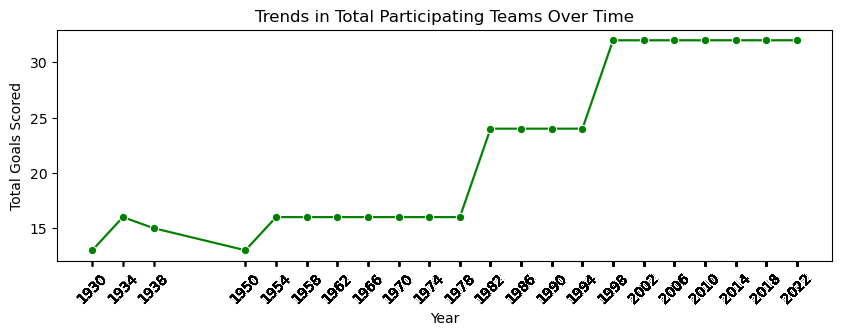

In [16]:
# 1. Number of teams participating over time

plt.figure(figsize=(10, 3))
sns.lineplot(data=merged_data, x='year', y='total_teams', color='green', marker='o')
plt.title('Trends in Total Participating Teams Over Time')
plt.xlabel('Year')
plt.ylabel('Total Goals Scored')
plt.xticks(ticks=merged_data['year'], rotation=45)

plt.show()

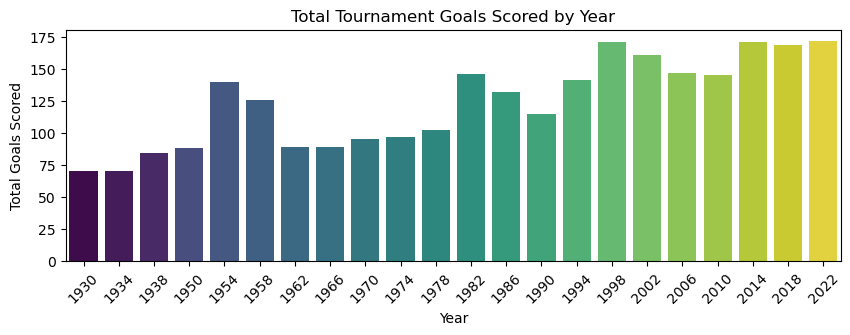

In [17]:
# 2. Total Goals Scored by Year

plt.figure(figsize=(10, 3))
sns.barplot(data=merged_data, x='year', y='total_tournament_goals_scored', hue = 'year', palette='viridis', legend=False)
plt.title('Total Tournament Goals Scored by Year')
plt.xlabel('Year')
plt.ylabel('Total Goals Scored')
plt.xticks(rotation=45)
plt.show()

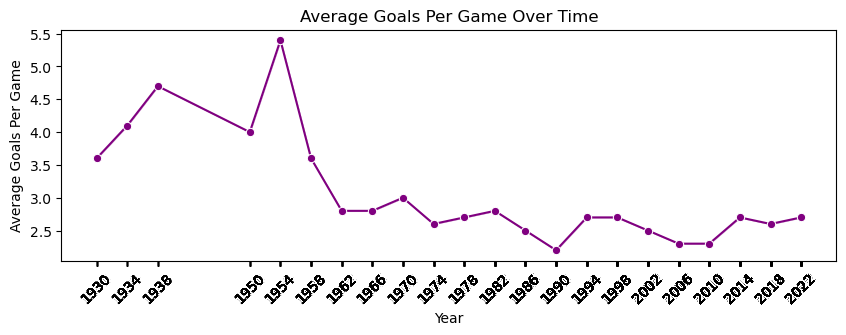

In [18]:
# 3.Average Goals Per Game Over Time

plt.figure(figsize=(10, 3))
sns.lineplot(data=merged_data, x='year', y='average_goals_per_game', color = 'purple', marker='o')
plt.title('Average Goals Per Game Over Time')
plt.xlabel('Year')
plt.ylabel('Average Goals Per Game')
plt.xticks(ticks=merged_data['year'], rotation=45)
plt.show()

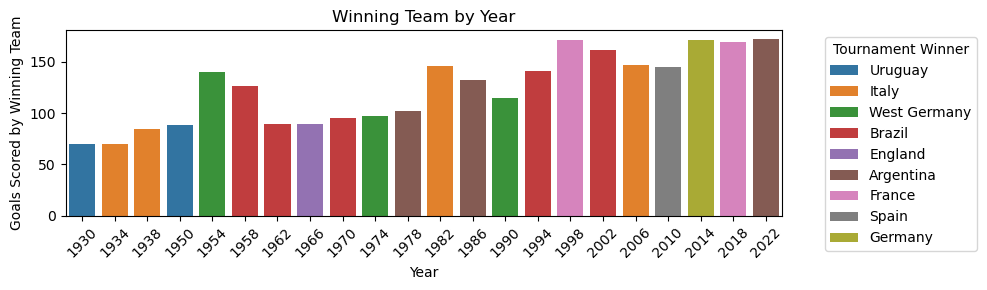

In [19]:
# 4. Bar Plot with Winning Team Names

plt.figure(figsize=(10, 3))

sns.barplot(data=merged_data, x='year', y='total_tournament_goals_scored', hue='tournament_winner', palette='tab10')

plt.title('Winning Team by Year')
plt.xlabel('Year')
plt.ylabel('Goals Scored by Winning Team')
plt.xticks(rotation=45)

# Move the legend outside the plot area
plt.legend(title='Tournament Winner', bbox_to_anchor=(1.05, 1))

# Adjust layout to prevent clipping
plt.tight_layout()

plt.show()

# 4.Feature Engineering

1. Calculate Total Goals for Tournament Winner

In [20]:
# Initialize the total goals column for the tournament winner
merged_data['tournament_winner_total_goals'] = 0

# Update the total goals scored by the tournament winner based on whether they were the home or away team
merged_data.loc[merged_data['home_team'] == merged_data['tournament_winner'], 'tournament_winner_total_goals'] = merged_data['home_score']
merged_data.loc[merged_data['away_team'] == merged_data['tournament_winner'], 'tournament_winner_total_goals'] += merged_data['away_score']

# Group by year and sum the goals for the tournament winner
total_goals_per_year = merged_data.groupby('year')['tournament_winner_total_goals'].sum().reset_index()
total_goals_per_year.columns = ['year', 'total_goals_by_winner']

merged_data = merged_data.drop(columns=['tournament_winner_total_goals'])

# Merge the total goals data back into the original DataFrame
merged_data = merged_data.merge(total_goals_per_year, on='year', how='left')

In [21]:
merged_data.head(2)

,date,year,tournament_host,stage,home_team,away_team,home_score,away_score,winning_team,losing_team,tournament_winner,tournament_second,tournament_third,tournament_fourth,total_tournament_goals_scored,average_goals_per_game,total_teams,total_games,total_attendance,total_goals_by_winner
0,1930-07-13,1930,Uruguay,Group 1,France,Mexico,4,1,France,Mexico,Uruguay,Argentina,USA,Yugoslavia,70,3.6,13,18,434000,15
1,1930-07-13,1930,Uruguay,Group 4,Belgium,USA,0,3,USA,Belgium,Uruguay,Argentina,USA,Yugoslavia,70,3.6,13,18,434000,15


2. Calculate Total Goals for Tournament Second

In [22]:
merged_data['tournament_second_total_goals'] = 0

merged_data.loc[merged_data['home_team'] == merged_data['tournament_second'], 'tournament_second_total_goals'] = merged_data['home_score']
merged_data.loc[merged_data['away_team'] == merged_data['tournament_second'], 'tournament_second_total_goals'] += merged_data['away_score']

total_goals_per_year = merged_data.groupby('year')['tournament_second_total_goals'].sum().reset_index()
total_goals_per_year.columns = ['year', 'total_goals_by_second']

merged_data = merged_data.merge(total_goals_per_year, on='year', how='left')

merged_data = merged_data.drop(columns=['tournament_second_total_goals'])

merged_data.head(2)

,date,year,tournament_host,stage,home_team,away_team,home_score,away_score,winning_team,losing_team,tournament_winner,tournament_second,tournament_third,tournament_fourth,total_tournament_goals_scored,average_goals_per_game,total_teams,total_games,total_attendance,total_goals_by_winner,total_goals_by_second
0,1930-07-13,1930,Uruguay,Group 1,France,Mexico,4,1,France,Mexico,Uruguay,Argentina,USA,Yugoslavia,70,3.6,13,18,434000,15,18
1,1930-07-13,1930,Uruguay,Group 4,Belgium,USA,0,3,USA,Belgium,Uruguay,Argentina,USA,Yugoslavia,70,3.6,13,18,434000,15,18


In [23]:
# Filter for the year 2022
filtered_merged_data = merged_data[merged_data['year'] == 2022]

# Select only the columns 'total_goals_by_winner' and 'total_goals_by_second'
result = filtered_merged_data[['total_goals_by_winner', 'total_goals_by_second']]

result.head(2)

,total_goals_by_winner,total_goals_by_second
900,15,16
901,15,16


If the tournament runner-up has a higher total goal count than the tournament winner, it suggests that the total number of goals alone may not be a decisive factor in determining success in the tournament. So we will perform more feature analysis going forward as required.

# 5.Time Series Analysis of Team Performance Metrics

1. Set Up the Data for Time Series Analysis

In [24]:
# Set the 'year' column as the index for time series analysis
time_series_data = merged_data[['year', 'total_goals_by_winner', 'total_goals_by_second']].drop_duplicates()

# Sort the data by year to ensure it's in chronological order
time_series_data = time_series_data.sort_values(by='year')

# Reset the index to ensure 'year' is the primary index for time series analysis
time_series_data.set_index('year', inplace=True)

# Display the prepared data
time_series_data.head()

,total_goals_by_winner,total_goals_by_second
year,,
1930,15,18
1934,12,9
1938,11,15
1950,15,22
1954,25,27


In [25]:
try:
    # Set the 'year' column as the index for time series analysis
    time_series_data = merged_data[['year', 'total_goals_by_winner', 'total_goals_by_second']].drop_duplicates()

    # Sort the data by year to ensure it's in chronological order
    time_series_data = time_series_data.sort_values(by='year')

    # Reset the index to ensure 'year' is the primary index for time series analysis
    time_series_data.set_index('year', inplace=True)

    # Display the prepared data
    time_series_data.head()

except KeyError as e:
    print(f"Error: {e}. Please check if the columns exist in the DataFrame.")

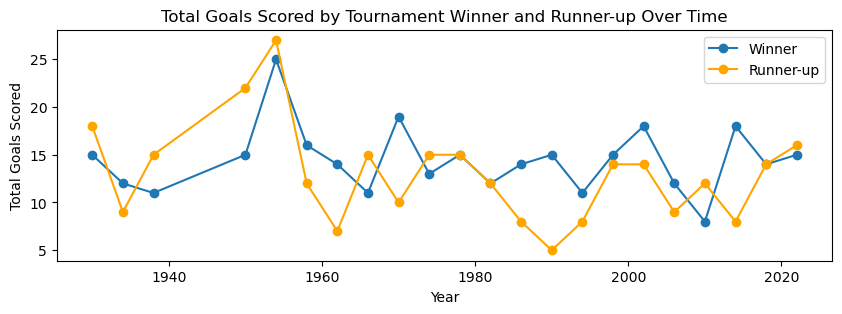

In [26]:
# Plot the total goals scored by the tournament winner and runner-up over time

plt.figure(figsize=(10, 3))
plt.plot(time_series_data.index, time_series_data['total_goals_by_winner'], marker='o', label='Winner')
plt.plot(time_series_data.index, time_series_data['total_goals_by_second'], marker='o', label='Runner-up', color='orange')

# Adding titles and labels
plt.title('Total Goals Scored by Tournament Winner and Runner-up Over Time')
plt.xlabel('Year')
plt.ylabel('Total Goals Scored')
plt.legend(loc='upper right')

plt.show()

2. Calculate Rolling Averages

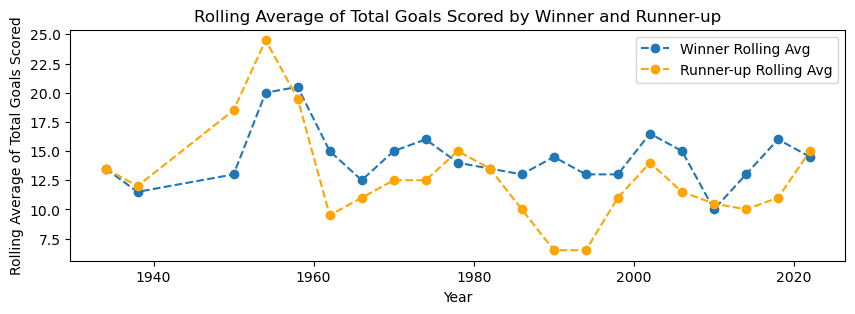

In [27]:
# Calculate the rolling average with a window of 2 years (you can adjust this window)
time_series_data['winner_rolling_avg'] = time_series_data['total_goals_by_winner'].rolling(window=2).mean()
time_series_data['second_rolling_avg'] = time_series_data['total_goals_by_second'].rolling(window=2).mean()

# Plot the rolling averages
plt.figure(figsize=(10, 3))
plt.plot(time_series_data.index, time_series_data['winner_rolling_avg'], marker='o', linestyle='--', label='Winner Rolling Avg')
plt.plot(time_series_data.index, time_series_data['second_rolling_avg'], marker='o', linestyle='--', label='Runner-up Rolling Avg', color='orange')

# Adding titles and labels
plt.title('Rolling Average of Total Goals Scored by Winner and Runner-up')
plt.xlabel('Year')
plt.ylabel('Rolling Average of Total Goals Scored')
plt.legend(loc='upper right')

plt.show()

3. Decompose the Time Series

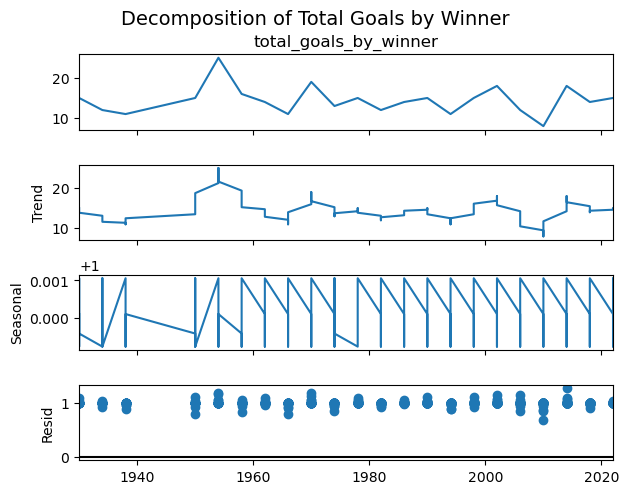

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure 'year' is used as an index for time series analysis
time_series_data = merged_data.set_index('year')

# Function to plot decomposition
def plot_decomposition(data, column, title):
    result = seasonal_decompose(data[column], model='multiplicative', period=4)

    result.plot()
    plt.suptitle(f'Decomposition of {title}', y=1.02, fontsize=14)
    plt.show()

# Plot decomposition for 'total_goals_by_winner'
plot_decomposition(time_series_data, 'total_goals_by_winner', 'Total Goals by Winner')

The decomposition plot for the total goals scored by the World Cup-winning teams reveals distinct components of the time series: trend, seasonal, and residual. The trend shows a relatively steady but slightly increasing pattern over time, with occasional peaks and dips. The seasonal component shows a recurring pattern, although it's quite minor, indicating that seasonal variation isn't strongly present in this series. The residuals (or noise) appear random, with no clear pattern, suggesting that most of the variability is captured by the trend and seasonal components.

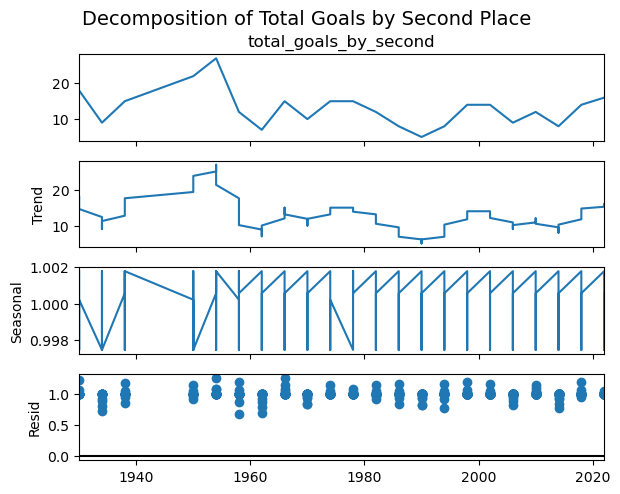

In [29]:
# Plot decomposition for 'total_goals_by_second'
plot_decomposition(time_series_data, 'total_goals_by_second', 'Total Goals by Second Place')

The trend component here indicates a slight increase over time, with less variability compared to the winner's goals trend. The seasonal component shows minor fluctuations, again indicating a limited seasonal effect. The residuals appear more dispersed, indicating more unexplained variability than in the winner's decomposition, possibly due to the less consistent performance of second-place teams.

In [30]:
merged_data.columns

Index(['date', 'year', 'tournament_host', 'stage', 'home_team', 'away_team',
       'home_score', 'away_score', 'winning_team', 'losing_team',
       'tournament_winner', 'tournament_second', 'tournament_third',
       'tournament_fourth', 'total_tournament_goals_scored',
       'average_goals_per_game', 'total_teams', 'total_games',
       'total_attendance', 'total_goals_by_winner', 'total_goals_by_second'],
      dtype='object')

# 6. Predicting Top 4 Teams for 2026 World Cup

1. I'll create a new dataframe 'team_stats', that includes only the relevant features for predicting the top 4 teams

In [31]:
# Step 1: Extract all teams from home and away matches, including duplicates

all_teams_home = wc_all_matches[['year', 'home_team']].rename(columns={'home_team': 'team'})
all_teams_away = wc_all_matches[['year', 'away_team']].rename(columns={'away_team': 'team'})

# Combine and drop duplicates to get the complete list of participating teams for each year

all_teams = pd.concat([all_teams_home, all_teams_away]).drop_duplicates().reset_index(drop=True)

In [32]:
# Step 2: Calculate total goals scored by each team (home and away combined)

home_goals_scored = wc_all_matches.groupby(['year', 'home_team'])['home_score'].sum().reset_index().rename(columns={'home_team': 'team', 'home_score': 'total_goals_scored'})
away_goals_scored = wc_all_matches.groupby(['year', 'away_team'])['away_score'].sum().reset_index().rename(columns={'away_team': 'team', 'away_score': 'total_goals_scored'})

# Combine home and away goals scored
total_goals_scored = pd.concat([home_goals_scored, away_goals_scored]).groupby(['year', 'team'])['total_goals_scored'].sum().reset_index()

In [33]:
# Step 3: Calculate total goals conceded by each team (home and away combined)

home_goals_conceded = wc_all_matches.groupby(['year', 'home_team'])['away_score'].sum().reset_index().rename(columns={'home_team': 'team', 'away_score': 'total_goals_conceded'})
away_goals_conceded = wc_all_matches.groupby(['year', 'away_team'])['home_score'].sum().reset_index().rename(columns={'away_team': 'team', 'home_score': 'total_goals_conceded'})

# Combine home and away goals conceded
total_goals_conceded = pd.concat([home_goals_conceded, away_goals_conceded]).groupby(['year', 'team'])['total_goals_conceded'].sum().reset_index()

In [34]:
# Step 4: Calculate win rate for each team

home_wins = wc_all_matches[wc_all_matches['winning_team'] == wc_all_matches['home_team']].groupby(['year', 'home_team']).size().reset_index(name='wins').rename(columns={'home_team': 'team'})
away_wins = wc_all_matches[wc_all_matches['winning_team'] == wc_all_matches['away_team']].groupby(['year', 'away_team']).size().reset_index(name='wins').rename(columns={'away_team': 'team'})

# Combine home and away wins
total_wins = pd.concat([home_wins, away_wins]).groupby(['year', 'team'])['wins'].sum().reset_index()

# Calculate total games played for each team
home_games_played = wc_all_matches.groupby(['year', 'home_team']).size().reset_index(name='games_played').rename(columns={'home_team': 'team'})
away_games_played = wc_all_matches.groupby(['year', 'away_team']).size().reset_index(name='games_played').rename(columns={'away_team': 'team'})

# Combine home and away games played
total_games_played = pd.concat([home_games_played, away_games_played]).groupby(['year', 'team'])['games_played'].sum().reset_index()

# Merge wins and games played to calculate win rate
win_rate = pd.merge(total_wins, total_games_played, on=['year', 'team'], how='left')
win_rate['win_rate'] = win_rate['wins'] / win_rate['games_played']

In [35]:
# Step 5: Merge all calculated stats with all_teams to include all teams, even those with no wins or goals

team_stats = pd.merge(all_teams, total_goals_scored, on=['year', 'team'], how='left')
team_stats = pd.merge(team_stats, total_goals_conceded, on=['year', 'team'], how='left')
team_stats = pd.merge(team_stats, win_rate[['year', 'team', 'win_rate']], on=['year', 'team'], how='left')

# Fill NaN values with 0 (for teams with no goals or wins)
team_stats.fillna(0, inplace=True)

In [36]:
# Step 6: Calculate extra features

team_stats['goal_difference'] = team_stats['total_goals_scored'] - team_stats['total_goals_conceded']

team_stats['win_percentage'] = team_stats['win_rate']*100
team_stats = team_stats.drop(columns=['win_rate'])

team_stats['avg_goals_scored_per_game'] = team_stats['total_goals_scored']/total_games_played['games_played']

In [37]:
# Final output

team_stats.sort_values(['year', 'team'], inplace=True)

# Reset the index to get a sequential order
team_stats.reset_index(drop=True, inplace=True)

team_stats.head()

,year,team,total_goals_scored,total_goals_conceded,goal_difference,win_percentage,avg_goals_scored_per_game
0,1930,Argentina,18,9,9,80.000000,6.000000
1,1930,Belgium,0,4,-4,0.000000,0.000000
2,1930,Bolivia,0,8,-8,0.000000,0.000000
3,1930,Brazil,5,2,3,50.000000,2.500000
4,1930,Chile,5,3,2,66.666667,1.666667


2. Preparing the Data for Classification

In [38]:
# 1: Create the Target Variable

# Reset the 'top_4_finish' column to 0
team_stats['top_4_finish'] = 0

# Correct the top_4_finish column
for year in team_stats['year'].unique():
    # Filter data for the current year
    year_data = team_stats[team_stats['year'] == year]
    
    # Sort the teams based on win_percentage and goal_difference to get the top 4 teams
    top_teams = year_data.sort_values(by=['win_percentage', 'goal_difference'], ascending=False).head(4)
    
    # Assign '1' to the top 4 teams for the current year
    team_stats.loc[top_teams.index, 'top_4_finish'] = 1

team_stats.head()

,year,team,total_goals_scored,total_goals_conceded,goal_difference,win_percentage,avg_goals_scored_per_game,top_4_finish
0,1930,Argentina,18,9,9,80.000000,6.000000,1
1,1930,Belgium,0,4,-4,0.000000,0.000000,0
2,1930,Bolivia,0,8,-8,0.000000,0.000000,0
3,1930,Brazil,5,2,3,50.000000,2.500000,0
4,1930,Chile,5,3,2,66.666667,1.666667,1


In [39]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Define features and target
X = team_stats.drop(columns=['top_4_finish'])
y = team_stats['top_4_finish']

# Convert all column names in X to strings
X.columns = X.columns.map(str)

# Check and ensure that all column names are strings
print("Column names:", X.columns)
print("Column types:", [type(col) for col in X.columns])

# Encode categorical variables and scale numerical features
categorical_features = ['team']
numeric_features = ['avg_goals_scored_per_game', 'total_goals_scored', 'total_goals_conceded','goal_difference', 'win_percentage']

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Apply the preprocessor
X_transformed = preprocessor.fit_transform(X)

# Get transformed feature names and ensure they are all strings
encoded_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
column_names = numeric_features + encoded_feature_names

# Convert transformed data into a DataFrame with proper column names
X_transformed_df = pd.DataFrame(X_transformed, columns=column_names)

# Ensure all column names in the transformed DataFrame are strings
X_transformed_df.columns = X_transformed_df.columns.astype(str)

print(X_transformed_df.head())

Column names: Index(['year', 'team', 'total_goals_scored', 'total_goals_conceded',
       'goal_difference', 'win_percentage', 'avg_goals_scored_per_game'],
      dtype='object')
Column types: [<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]
   avg_goals_scored_per_game  total_goals_scored  total_goals_conceded  \
0                   1.934405            2.750584              1.253228   
1                  -0.792286           -1.226490             -0.563582   
2                  -0.792286           -1.226490              0.889866   
3                   0.343835           -0.121747             -1.290306   
4                  -0.034872           -0.121747             -0.926944   

   goal_difference  win_percentage  team_Algeria  team_Angola  team_Argentina  \
0         1.904201        1.714826           0.0          0.0             1.0   
1        -0.846312       -1.253495           0.0          0.0             0.0   
2        -1.6

3.Train-Test Split

In [40]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.3, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (343, 91)
X_test shape: (147, 91)
y_train shape: (343,)
y_test shape: (147,)


4. Model Training

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9455782312925171

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       119
           1       0.95      0.75      0.84        28

    accuracy                           0.95       147
   macro avg       0.95      0.87      0.90       147
weighted avg       0.95      0.95      0.94       147



The model shows an accuracy of 94.56%, with a strong precision of 0.94 for class 0 (non-top 4 teams) and 0.95 for class 1 (top 4 teams). The recall for class 0 is excellent at 0.99, indicating that nearly all non-top 4 teams are correctly identified, while the recall for class 1 is 0.75, meaning some top 4 teams are still missed. The weighted average f1-score is 0.94, reflecting an overall well-balanced model performance, but there is room for improvement in correctly identifying top 4 teams (class 1).

5. Feature Importance Analysis

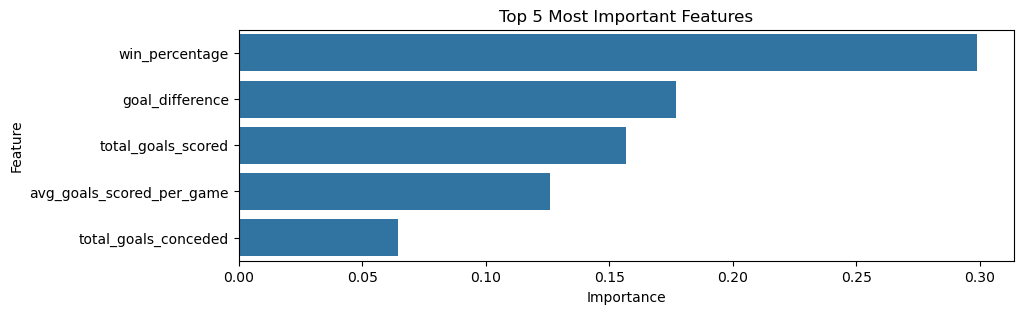

In [42]:
# Importing the necessary library for feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 5 most important features
plt.figure(figsize=(10, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(5))
plt.title('Top 5 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

6. Model Evaluation

In [43]:
# 1. Cross-Validation - to ensure the model's performance is consistent across different data subsets.

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores and mean accuracy
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

Cross-validation scores: [0.95652174 0.94202899 0.92753623 0.94117647 0.89705882]
Mean cross-validation accuracy: 0.9329


1. Cross-validation scores: The cross-validation results show that the model has consistently high performance across different folds, with individual accuracy scores ranging from approximately 89.7% to 95.6%.
2. Mean cross-validation accuracy: The mean cross-validation accuracy is 93.2%, indicating that the model is robust and generalizes well to unseen data.

The slight variation in scores suggests stable and reliable predictive power, though there may be room for slight improvements.

# 7. Use the Existing Data for Prediction

1. Identify Common Teams from 2018 and 2022 World Cups -

I will be using the common 32 teams from the 2018 and 2022 FIFA World Cups as this is a practical approach for creating the hypothetical 2026 dataset. This way, I can base the predictions on teams that have consistently performed well in recent tournaments.

In [44]:
# 1. Identify Common Teams for 2018 and 2022 separately

teams_2018 = team_stats[team_stats['year'] == 2018]
teams_2022 = team_stats[team_stats['year'] == 2022]

common_teams = list(set(teams_2018['team']).intersection(set(teams_2022['team'])))

In [45]:
# Merge data for common teams based on the 'team' column

common_teams_2018 = teams_2018[teams_2018['team'].isin(common_teams)]
common_teams_2022 = teams_2022[teams_2022['team'].isin(common_teams)]

common_teams_merged = pd.merge(common_teams_2018, common_teams_2022, on='team', suffixes=('_2018', '_2022'))

In [46]:
# Calculate combined/averaged metrics

common_teams_merged['total_goals_scored'] = common_teams_merged['total_goals_scored_2018'] + common_teams_merged['total_goals_scored_2022']
common_teams_merged['total_goals_conceded'] = common_teams_merged['total_goals_conceded_2018'] + common_teams_merged['total_goals_conceded_2022']
common_teams_merged['goal_difference'] = common_teams_merged['goal_difference_2018'] + common_teams_merged['goal_difference_2022']
common_teams_merged['win_percentage'] = (common_teams_merged['win_percentage_2018'] + common_teams_merged['win_percentage_2022']) / 2
common_teams_merged['avg_goals_scored_per_game'] = (common_teams_merged['avg_goals_scored_per_game_2018'] + common_teams_merged['avg_goals_scored_per_game_2022']) / 2

In [47]:
# Set year to 2026 for these teams
common_teams_merged['year'] = 2026

# Select only the relevant columns for the final dataframe
common_teams_final = common_teams_merged[['year', 'team', 'total_goals_scored', 'total_goals_conceded', 'goal_difference', 'win_percentage', 'avg_goals_scored_per_game']]

# Reset index
common_teams_final = common_teams_final.reset_index(drop=True)

common_teams_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       23 non-null     int64  
 1   team                       23 non-null     object 
 2   total_goals_scored         23 non-null     int64  
 3   total_goals_conceded       23 non-null     int64  
 4   goal_difference            23 non-null     int64  
 5   win_percentage             23 non-null     float64
 6   avg_goals_scored_per_game  23 non-null     float64
dtypes: float64(2), int64(4), object(1)
memory usage: 1.4+ KB


2. Select Additional Teams based on win_percentage (as there are only 23 common teams)

In [48]:
# Filter non-common teams for 2018 and 2022
non_common_teams_2018 = teams_2018[~teams_2018['team'].isin(common_teams)]
non_common_teams_2022 = teams_2022[~teams_2022['team'].isin(common_teams)]

# Combine non-common teams from both years
non_common_teams = pd.concat([non_common_teams_2018, non_common_teams_2022])

# Sort by performance metrics (e.g., win_percentage, goal_difference) to prioritize selection
non_common_teams_sorted = non_common_teams.sort_values(by=['win_percentage', 'goal_difference'], ascending=[False, False])

# Select top performing teams to complete the set of 32 teams
# Calculate how many more teams are needed
remaining_slots = 32 - len(common_teams_final)
selected_additional_teams = non_common_teams_sorted.head(remaining_slots)

In [49]:
# Update year to 2026 for these teams
selected_additional_teams['year'] = 2026

# Select only the relevant columns
selected_additional_teams = selected_additional_teams[['year', 'team', 'total_goals_scored', 'total_goals_conceded', 'goal_difference', 'win_percentage', 'avg_goals_scored_per_game']]

# Combine with common teams to form the final dataset for prediction
final_team_stats_2026 = pd.concat([common_teams_final, selected_additional_teams]).reset_index(drop=True)

# Display the final dataframe
final_team_stats_2026

,year,team,total_goals_scored,total_goals_conceded,goal_difference,win_percentage,avg_goals_scored_per_game
0,2026,Argentina,21,17,4,55.357143,2.071429
1,2026,Australia,6,11,-5,25.000000,0.916667
2,2026,Belgium,17,8,9,59.523810,2.833333
3,2026,Brazil,16,6,10,60.000000,2.333333
4,2026,Costa Rica,5,16,-11,16.666667,0.517857
5,2026,Croatia,22,16,6,71.428571,3.333333
6,2026,Denmark,4,5,-1,12.500000,0.666667
7,2026,England,25,12,13,58.571429,4.166667
8,2026,France,30,14,16,78.571429,3.350000
9,2026,Germany,8,9,-1,33.333333,1.200000


3. Prepare Data for Prediction

In [50]:
from sklearn.preprocessing import StandardScaler

# Select the relevant features for prediction along with the 'team' column
X_2026 = final_team_stats_2026[['team', 'total_goals_scored', 'total_goals_conceded', 'goal_difference', 'win_percentage', 'avg_goals_scored_per_game']]

# Extract the team names separately
teams = X_2026['team']

# Drop the 'team' column for scaling and prediction
X_2026_features = X_2026.drop(columns=['team'])

# Apply scaling (if the model was trained on scaled data)
scaler = StandardScaler()
X_2026_scaled = scaler.fit_transform(X_2026_features)

# Convert back to a DataFrame and add the team column back
X_2026_scaled_df = pd.DataFrame(X_2026_scaled, columns=X_2026_features.columns)
X_2026_scaled_df['team'] = teams.values

X_2026_scaled_df = X_2026_scaled_df[['team'] + list(X_2026_features.columns)]

# Display the prepared data for prediction
X_2026_scaled_df.head()

,team,total_goals_scored,total_goals_conceded,goal_difference,win_percentage,avg_goals_scored_per_game
0,Argentina,1.585544,1.931371,0.483480,0.869782,0.489018
1,Australia,-0.570437,0.521397,-1.063656,-1.003383,-0.638284
2,Belgium,1.010616,-0.183590,1.343000,1.126884,1.232804
3,Brazil,0.866884,-0.653582,1.514903,1.156267,0.744695
4,Costa Rica,-0.714169,1.696375,-2.095079,-1.517586,-1.027609


In [51]:
# Get the original feature names used during model training
model_features = rf_model.feature_names_in_

# Initialize a new DataFrame with all features, filling missing features with zeros
X_2026_aligned = pd.DataFrame(0, index=np.arange(len(X_2026_scaled_df)), columns=model_features)

# Populate the aligned DataFrame with the relevant features from X_2026_scaled_df
for col in X_2026_scaled_df.columns:
    if col in model_features:
        X_2026_aligned[col] = X_2026_scaled_df[col]

In [52]:
# Make predictions using the trained model
predictions_2026 = rf_model.predict(X_2026_aligned)

# Get prediction probabilities for class 1 (top 4)
prediction_probs = rf_model.predict_proba(X_2026_aligned)[:, 1]

# Add the prediction probabilities to the final dataframe
final_team_stats_2026['top_4_probability'] = prediction_probs

# Sort the teams by their prediction probability in descending order
final_team_stats_2026_sorted = final_team_stats_2026.sort_values(by='top_4_probability', ascending=False)

# Select the top 4 teams
top_4_teams = final_team_stats_2026_sorted.head(4)

top_4_teams = top_4_teams.reset_index(drop=True)

# Display the top 4 teams with their probabilities
top_4_teams_final = top_4_teams[['team', 'top_4_probability']]

print(top_4_teams_final)

      team  top_4_probability
0   France               0.96
1  Belgium               0.87
2   Brazil               0.81
3  Croatia               0.67


So as we can see, as per my model, the Top 4 probable teams in the 2026 FIFA World Cup are -  
* France
* Belgium
* Brazil
* Croatia

# Thank You,
# Hryshikesh Dihingia